In [2]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15
!pip3 install 'keras==2.2.4'
!pip install h5py==2.10.0
!pip install pretty-confusion-matrix
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 21 kB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 3.8 MB 48.3 MB/s 
     |████████████████████████████████| 503 kB 53.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=10fabdeb71066efb08269767d63edb3389419ba1e71c9eecab21fe084ace5dae
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [3]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.callbacks import Callback
import tensorflow_hub as hub
import tensorflow as tf
import re

import keras.backend as K
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, Embedding, Flatten, Activation, SpatialDropout1D
from keras.layers import Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Layer
from keras import initializers, regularizers, constraints
from keras.layers import *
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, CuDNNGRU, CuDNNLSTM, Add, Reshape
from keras.layers import MaxPooling1D, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, balanced_accuracy_score \
                            ,matthews_corrcoef, average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from pretty_confusion_matrix import pp_matrix_from_data

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'
import re
import math

Using TensorFlow backend.


Loading the Dataset ( pour la suite)

In [4]:
# downloading the dataset from the url
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
#unzip the files
!unzip snli_1.0.zip

# importing the dataset into dataframes
df_train = pd.read_csv("snli_1.0/snli_1.0_train.txt", sep="\t")
df_dev = pd.read_csv("snli_1.0/snli_1.0_dev.txt", sep="\t")
df_test = pd.read_csv("snli_1.0/snli_1.0_test.txt", sep="\t")

# extracting the required columns form the dataset
df_train = df_train[['gold_label','sentence1','sentence2']]
df_dev = df_dev[['gold_label','sentence1','sentence2']]
df_test = df_test[['gold_label','sentence1','sentence2']]

# Analyzing the data
df_train.groupby('gold_label').count()

--2022-10-13 18:06:17--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  26.5MB/s    in 5.4s    

2022-10-13 18:06:22 (16.8 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]

Archive:  snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/snli_1.0/
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_

,sentence1,sentence2
gold_label,,
-,785,785
contradiction,183187,183185
entailment,183416,183414
neutral,182764,182762


In [5]:
# removing the entries from all train, dev and test datasets with label '-'
df_train = df_train[df_train['gold_label'] != '-']
df_dev = df_dev[df_dev['gold_label'] != '-']
df_test = df_test[df_test['gold_label'] != '-']

df_test = df_test.head(200)

In [6]:
# dropping the rows from the data with NaN values
df_train = df_train.dropna(subset = ['sentence2'])
df_train.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,183185,183185
entailment,183414,183414
neutral,182762,182762


# Model 

In [7]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
    
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        # do not pass the mask to the next layers   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
        
custom_ob={'ElmoEmbeddingLayer': ElmoEmbeddingLayer, 'NonMasking': NonMasking}

In [8]:
#### Elmo attempt
def get_model():
    model = Sequential()
    inp1 = Input(shape=(1,), dtype="string", name="sentence1")
    inp2 = Input(shape=(1,), dtype="string", name="sentence2")
    
    def emb_layer(inp, col):
        x = ElmoEmbeddingLayer()(inp)
        return x

    x = concatenate([emb_layer(inp1,"sen_1"),emb_layer(inp2,"sen_2"),])
    
    x = NonMasking()(x)
    x = Reshape((1, 1024*2), input_shape=(1024*2,))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    outp = Dense(3, activation="softmax", name="final_output")(x)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'],
                 )

    return model

model = get_model()

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
sentence2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_1 (ElmoEmb (None, 1024)         4           sentence1[0][0]                  
__________________________________________________________________________________________________
elmo_embedding_layer_2 (ElmoEmb (None, 1024)         4           sentence2[0][0]                  
__________________________________________________________________________________________________
concatenat

In [9]:
# Upload d'un csv sous colab (pas besoin de faire ça si vous êtes en local sur votre machine)
# Dans votre navigateur web, les cookies tiers doivent être autorisés pour cette opération.
# N'oubliez pas de les rebloquer par la suite ;-)
from google.colab import files
up = files.upload()

Saving SNLI_weights.hdf5 to SNLI_weights.hdf5


In [10]:
model.load_weights("SNLI_weights.hdf5")
for layer in model.layers:
    weights = layer.get_weights()

In [11]:
%%time
def get_rnn_data(df):
    x = {
        'sentence1': df["sentence1"],
        #
        'sentence2': df["sentence2"],
        }
    return x
le = LabelEncoder()
X_test = get_rnn_data(df_test)
Y_test = np_utils.to_categorical(le.fit_transform(df_test["gold_label"].values)).astype("int64")

CPU times: user 4.82 ms, sys: 0 ns, total: 4.82 ms
Wall time: 4.8 ms


In [12]:
%%time
 
test_pred = model.predict(X_test, batch_size=128)

CPU times: user 1min 13s, sys: 5.28 s, total: 1min 18s
Wall time: 45.2 s


In [13]:
test_acc = (np.argmax(test_pred, axis=1) == np.argmax(Y_test, axis=1)).sum()/Y_test.shape[0] * 100

print("Accuracy on test set is: %"+str(test_acc))

Accuracy on test set is: %76.0


In [16]:
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1),(np.argmax(test_pred, axis=1)))

In [17]:
Y_test = np.argmax(Y_test, axis=1)
test_pred = np.argmax(test_pred, axis=1)

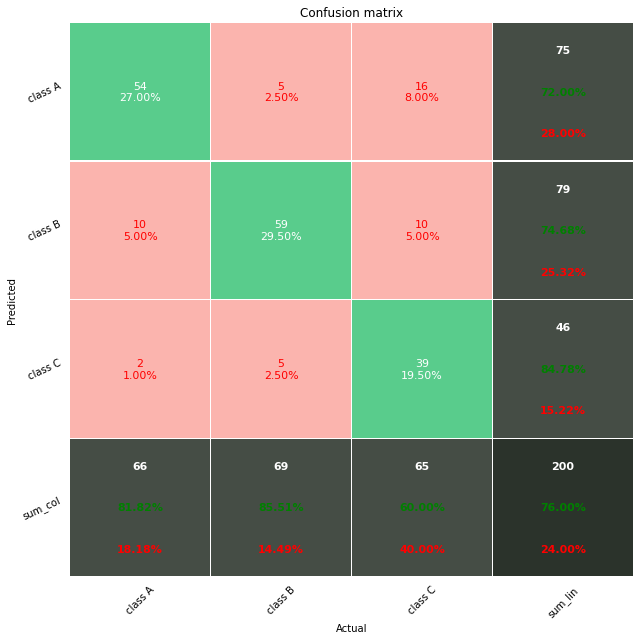

In [21]:
pp_matrix_from_data(Y_test, test_pred, cmap='Pastel1')

In [22]:
print(classification_report(Y_test, test_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77        66
           1       0.75      0.86      0.80        69
           2       0.85      0.60      0.70        65

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.76      0.76       200

